In [46]:
import sys
sys.path.append('../')

from low_rank_rnns.modules import *
from low_rank_rnns import TF, TFD, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook


In [47]:
size = 100
noise_std = 5e-2
alpha = .2
lr = 1e-2

# TF interruption analysis

In [48]:
# load a low-rank RNN

x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=3)
net_lo.load_state_dict(torch.load(f'../models/TF_rank3_{size}.pt', map_location='cpu'))

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.040, acc=1.000


In [ ]:
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()


# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()


wo = net_lo.wo.detach().squeeze().numpy()

In [49]:
# 1st way to generate low-traj
loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

loss=0.040, acc=1.000


In [50]:
TOn = 10
COn = 150
# project low rank rnn traj on m1 vector
kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size


colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']

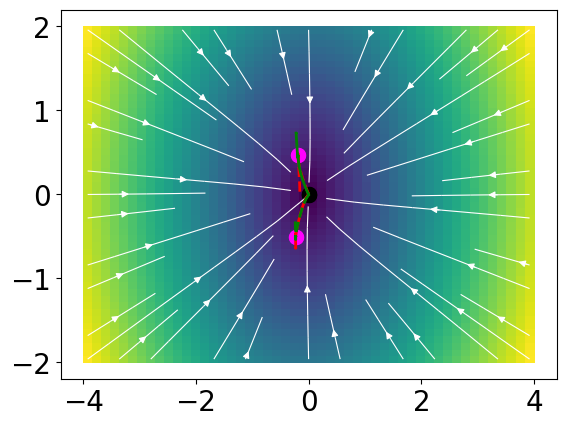

In [51]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m2, -4, 4, -2, 2)
for i in range(4):
     plt.plot(kap3[i], kap2[i], c=colors[i], lw=2, ls=lineStyle[i])
     plt.scatter(kap3[i, TOn], kap2[i, TOn], c= 'black',
            marker='.', s=400)  
     plt.scatter(kap3[i, COn], kap2[i, COn], c= 'magenta',
            marker='.', s=400)    
plt.show()

In [55]:
inputs, off_time, _, allContext = TF.generate_interrupt_inputs(10, interrupt_type = 'targets')

y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
traj_inter1 = traj_inter.detach().numpy()
off_time1 = off_time.detach().numpy()


TOn = 10
COn = 150
# project low rank rnn traj on m1 vector
kap1 = traj_inter1 @ m1 / size
kap2 = traj_inter1 @ m2 / size
kap3 = traj_inter1 @ m3 / size

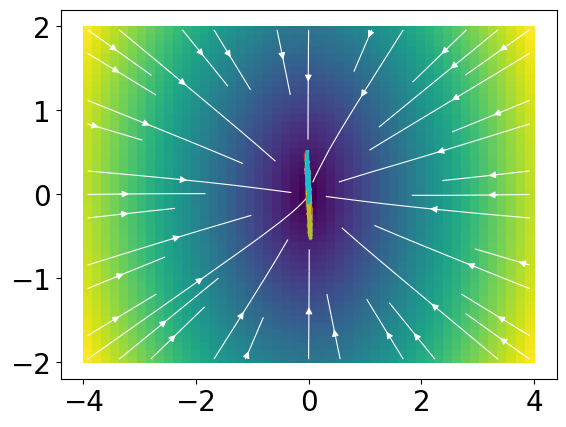

In [56]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m3, m2, -4, 4, -2, 2)
for i in range(kap1.shape[0]):
     plt.plot(kap3[i,:], kap2[i,:], lw=2)
#      plt.scatter(kap3[i, TOn], kap2[i, TOn], c= 'black',
#             marker='.', s=400)  
   
plt.show()

In [57]:
inputs, off_time, allCoh, _ = TF.generate_interrupt_inputs(10, interrupt_type = 'checkerboard')

y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
traj_inter1 = traj_inter.detach().numpy()
off_time1 = off_time.detach().numpy()


TOn = 10
COn = 150
# project low rank rnn traj on m1 vector
kap1 = traj_inter1 @ m1 / size
kap2 = traj_inter1 @ m2 / size
kap3 = traj_inter1 @ m3 / size

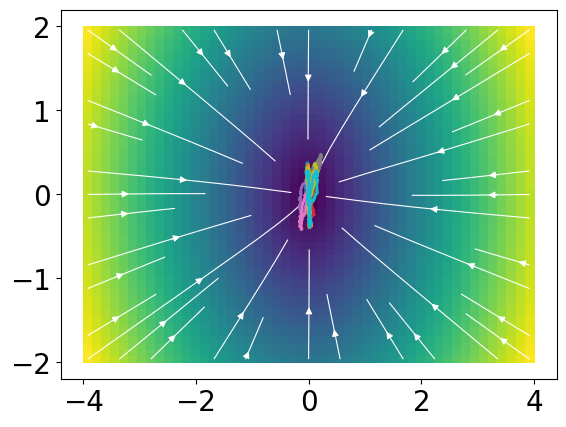

In [59]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m3, m2, -4, 4, -2, 2)
for i in range(kap1.shape[0]):
     plt.plot(kap3[i,:], kap2[i,:], lw=2)
#      plt.scatter(kap3[i, TOn], kap2[i, TOn], c= 'black',
#             marker='.', s=400)  
   
plt.show()

# TFD interrupt


In [64]:
# load a low-rank RNN

rank = 4
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TFD.generate_checker_data(5000)

net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank)
net_lo.load_state_dict(torch.load(f'../models/TFD_rank4_{size}.pt', map_location='cpu'))

loss, acc, out, decisions, target_decisions, traj = TFD.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.043, acc=1.000


In [ ]:
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()


# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()


wo = net_lo.wo.detach().squeeze().numpy()

In [65]:
# 1st way to generate low-traj
loss, acc, out, decisions, target_decisions, traj = TFD.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

loss=0.043, acc=1.000


In [66]:

# project low rank rnn traj on m1 vector
kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size
# kap4 = trajLow @ m4 / size

colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
TOn = 10
COn = 160
TOff = 100

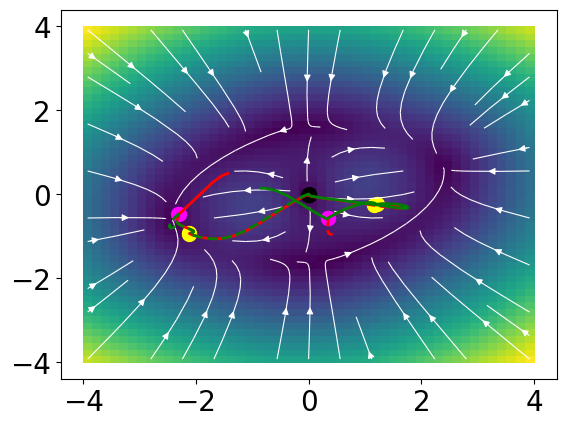

In [67]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -4, 4, -4, 4)
for i in range(4):
     plt.plot(kap1[i], kap3[i], c=colors[i], lw=2, ls=lineStyle[i])
     plt.scatter(kap1[i, TOn], kap3[i, TOn], c= 'black',
            marker='.', s=400)  
     plt.scatter(kap1[i, COn], kap3[i, COn], c= 'magenta',
            marker='.', s=400)  
     plt.scatter(kap1[i, TOff], kap3[i, TOff], c= 'yellow',
        marker='.', s=400)
plt.show()

In [77]:
inputs, off_time, _, allContext = TFD.generate_interrupt_inputs(10, interrupt_type = 'targets')

y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
traj_inter1 = traj_inter.detach().numpy()
off_time1 = off_time.detach().numpy()


TOn = 10

# project low rank rnn traj on m1 vector
kap1 = traj_inter1 @ m1 / size
kap2 = traj_inter1 @ m2 / size
kap3 = traj_inter1 @ m3 / size

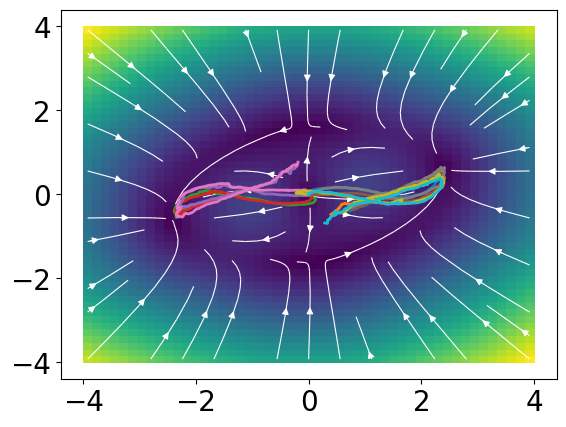

In [78]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -4, 4, -4, 4)
for i in range(kap1.shape[0]):
     plt.plot(kap1[i,:], kap3[i,:], lw=2)

plt.show()

In [70]:
inputs, off_time, _, allContext = TFD.generate_interrupt_inputs(10, interrupt_type = 'checkerboard')

y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
traj_inter1 = traj_inter.detach().numpy()
off_time1 = off_time.detach().numpy()


TOn = 10

# project low rank rnn traj on m1 vector
kap1 = traj_inter1 @ m1 / size
kap2 = traj_inter1 @ m2 / size
kap3 = traj_inter1 @ m3 / size

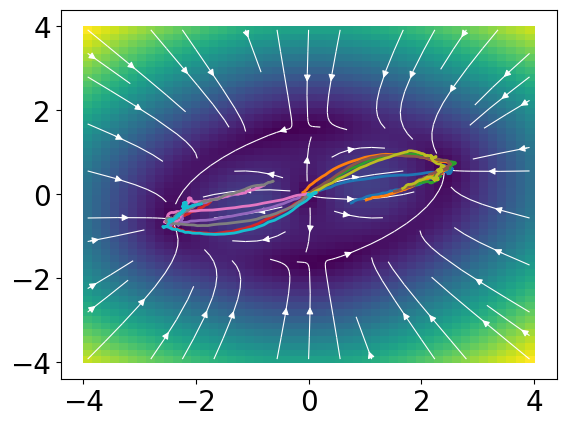

In [71]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -4, 4, -4, 4)
for i in range(kap1.shape[0]):
     plt.plot(kap1[i,:], kap3[i,:], lw=2)

plt.show()